* `Import Libraries`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import joblib

from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


 * `Read Datasets`

In [2]:
DATA_PATH=os.path.join(os.getcwd(),'..','Datasets','Churn_Modelling.csv')
DF=pd.read_csv(DATA_PATH)
DF.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
DF.columns=DF.columns.str.strip().str.replace(' ','_')

In [4]:
# Adjust columns name
DF.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
# Drop RowNumber and CustomerId and Surname

df = DF.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


* `EDA`

In [8]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [9]:
#Geography
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [10]:
#Gender
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [11]:
# Target
df['Exited'].value_counts(normalize=True)


Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [12]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [23]:
# Tenure
df['Tenure'].value_counts()

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64

* `Data Visualization and Handling Outliers`

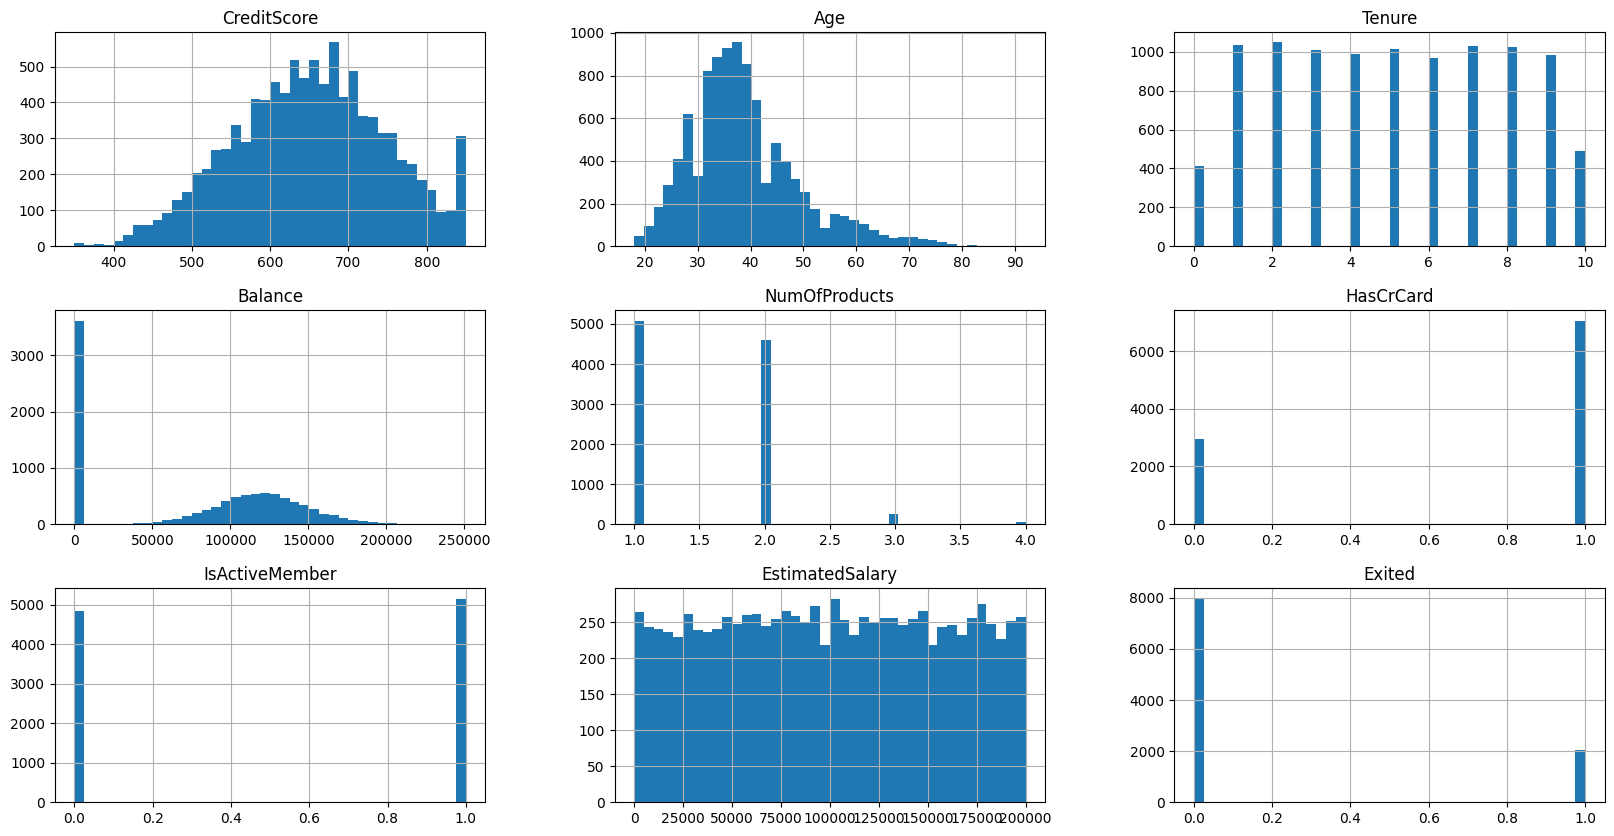

In [6]:
#Numerical Column
df.hist(bins=40,figsize=(20,10))
plt.show()

In [6]:
df[df['Age']>80]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
766,700,France,Female,82,2,0.00,2,0,1,182055.36,0
2458,513,Spain,Male,88,10,0.00,2,1,1,52952.24,0
3033,787,France,Female,85,10,0.00,2,1,1,116537.96,0
3387,537,Germany,Male,84,8,92242.34,1,1,1,186235.98,0
3531,408,France,Female,84,8,87873.39,1,0,0,188484.52,1
4931,682,Germany,Male,81,6,122029.15,1,1,1,50783.88,0
6443,753,France,Male,92,3,121513.31,1,0,1,195563.99,0
6759,705,France,Male,92,1,126076.24,2,1,1,34436.83,0
7526,850,France,Female,81,1,0.00,2,1,1,59568.24,0
7956,850,France,Male,81,5,0.00,2,1,1,44827.47,0


In [7]:
df.drop(index=df[df['Age']>80].index.tolist(),axis=0,inplace=True)

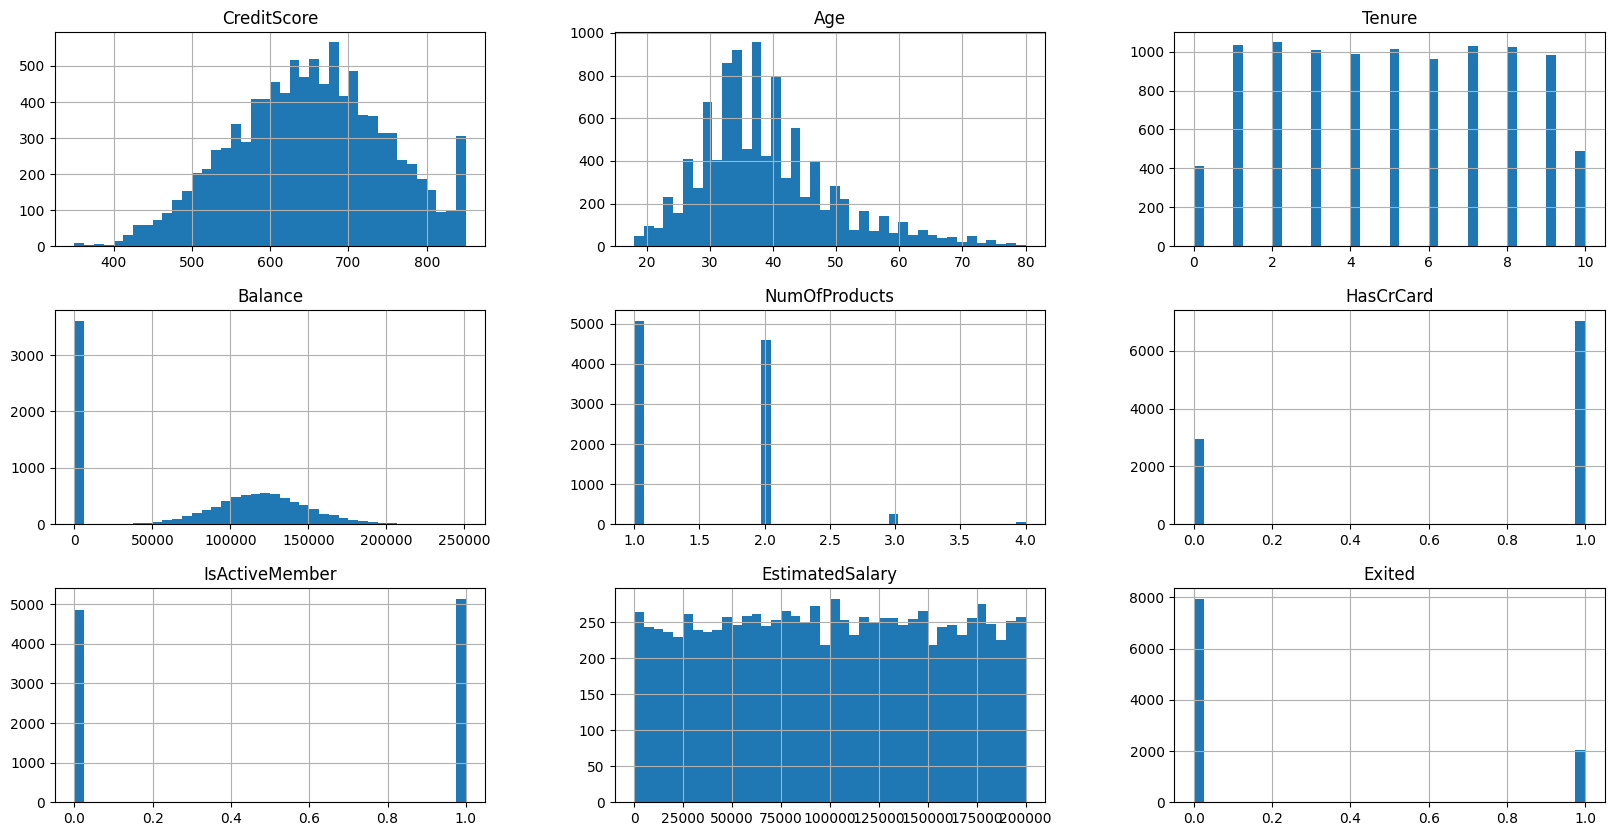

In [28]:
#Numerical Column
df.hist(bins=40,figsize=(20,10))
plt.show()

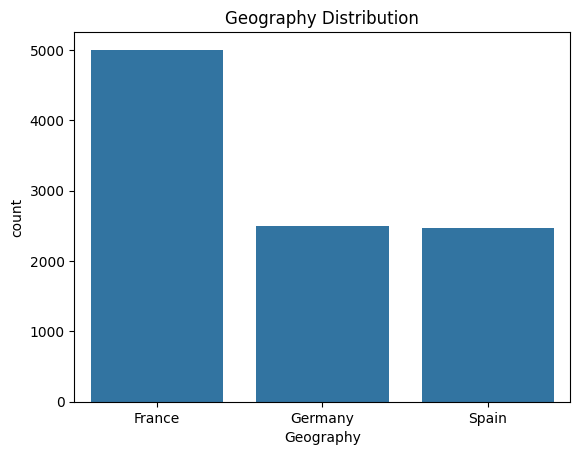

In [29]:
sns.countplot(data=df,x='Geography',order=df['Geography'].value_counts().index.tolist())
plt.title('Geography Distribution')
plt.show()


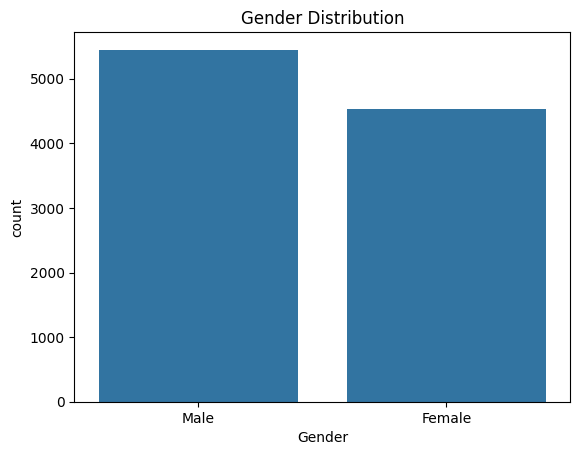

In [31]:
sns.countplot(data=df, x='Gender' ,order=df['Gender'].value_counts().index.tolist())
plt.title('Gender Distribution')
plt.show()

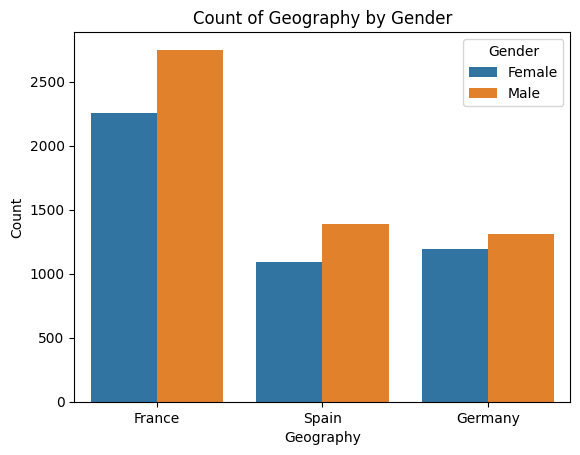

In [35]:
sns.countplot(data=df,x='Geography',hue='Gender')
plt.title('Count of Geography by Gender')
plt.xlabel("Geography")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()

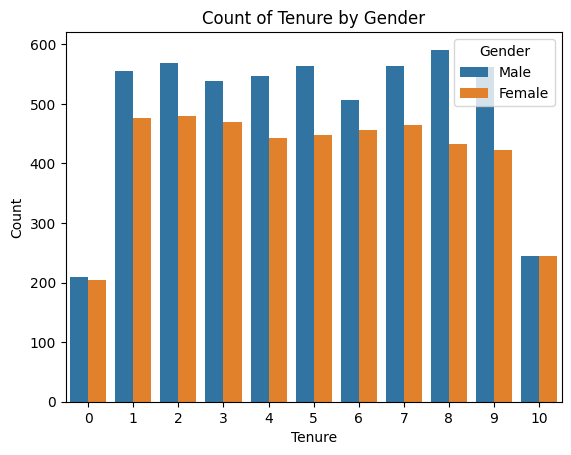

In [36]:
sns.countplot(data=df,x='Tenure',hue='Gender')
plt.title('Count of Tenure by Gender')
plt.xlabel("Tenure")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()

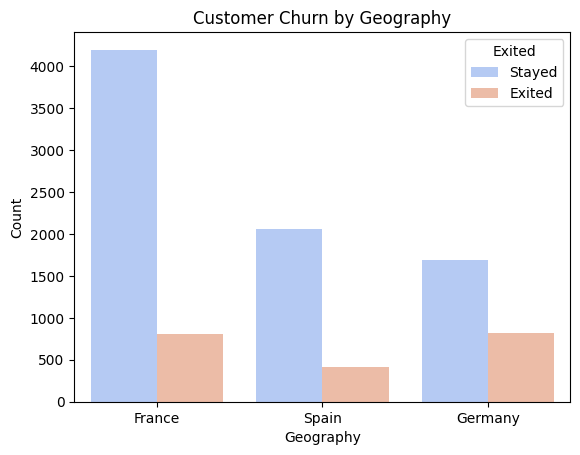

In [37]:
sns.countplot(data=df, x="Geography", hue="Exited", palette="coolwarm")
plt.title("Customer Churn by Geography")
plt.xlabel("Geography")
plt.ylabel("Count")
plt.legend(title="Exited", labels=["Stayed", "Exited"])
plt.show()


<Axes: ylabel='EstimatedSalary'>

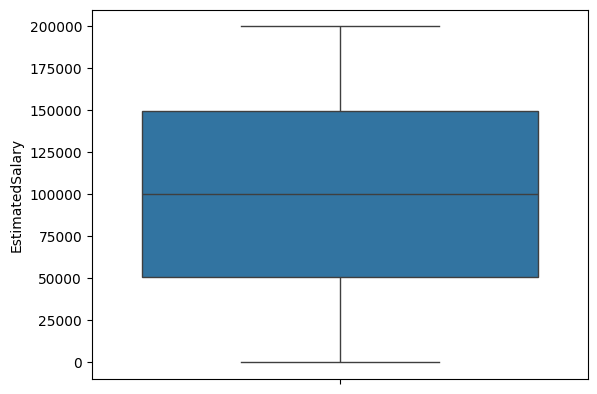

In [33]:
sns.boxplot(data=df,y='EstimatedSalary')

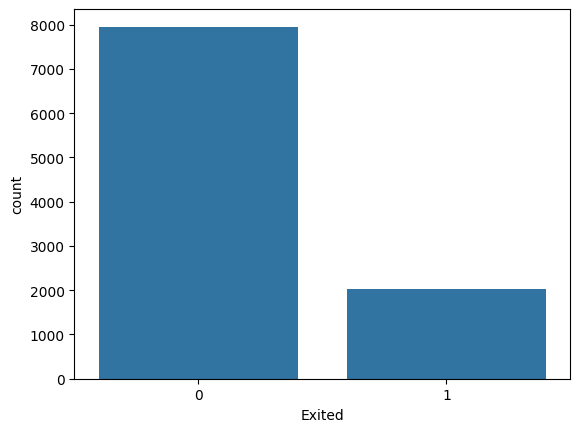

In [38]:
sns.countplot(data=df,x='Exited')
plt.show()

In [39]:
# Averge salery per Gender
df[['Gender','EstimatedSalary']].groupby('Gender')['EstimatedSalary'].mean()

Gender
Female    100575.998277
Male       99671.901194
Name: EstimatedSalary, dtype: float64

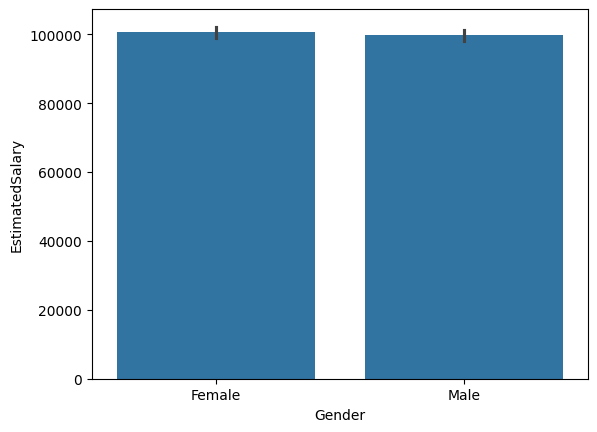

In [42]:
sns.barplot(data=df,y='EstimatedSalary',x='Gender',estimator='mean')
plt.show()

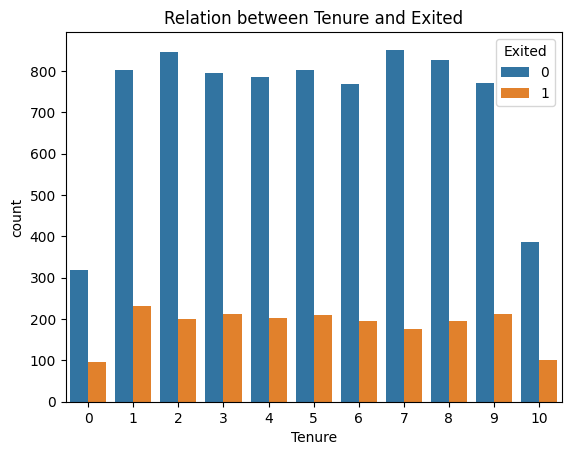

In [43]:
# Realation between Tenure and Exited
sns.countplot(data=df,x='Tenure',hue='Exited')
plt.title('Relation between Tenure and Exited')
plt.show()

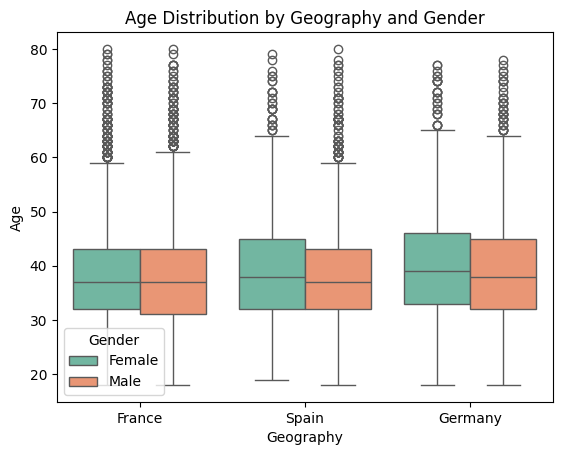

In [45]:
sns.boxplot(data=df, x="Geography", y="Age", hue="Gender", palette="Set2")
plt.title("Age Distribution by Geography and Gender")
plt.xlabel("Geography")
plt.ylabel("Age")
plt.legend(title="Gender")
plt.show()

* `Split to Train and Test`

In [8]:
# To featueres and target
X=df.drop(columns=['Exited'])
y=df['Exited']

# To Train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True,stratify=y)

# Check shapes
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(7990, 10) (1998, 10) (7990,) (1998,)


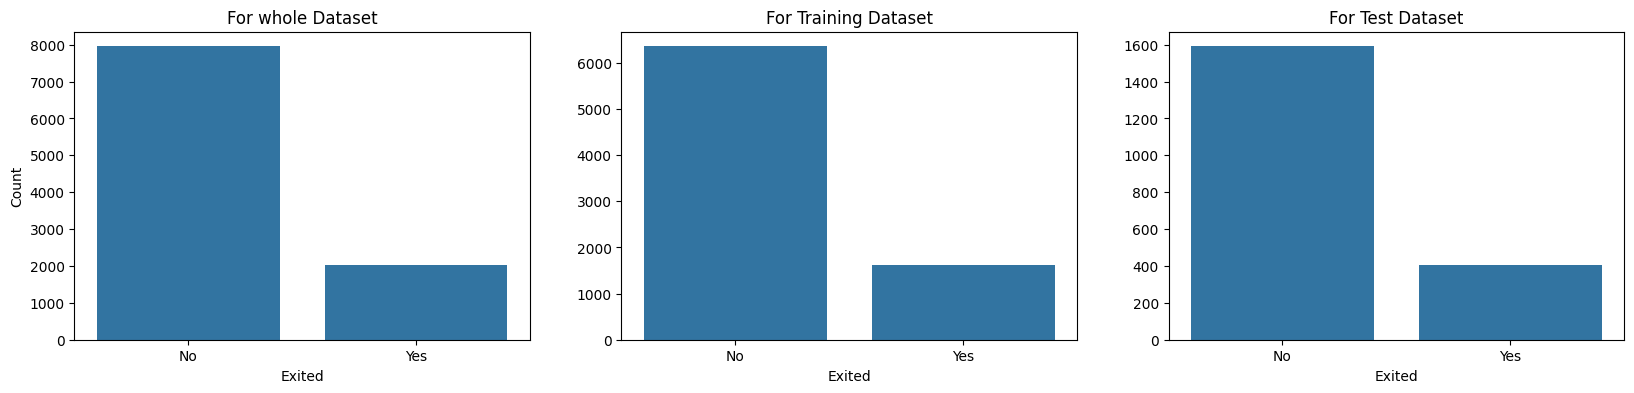

In [9]:
# Plotting to Check
fig,ax=plt.subplots(1 , 3,figsize=(20,4))

# whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For whole Dataset')
plt.ylabel('Count')
plt.xticks(ticks=[0,1],labels=['No','Yes'])

# Train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Dataset')
plt.ylabel('')
plt.xticks(ticks=[0,1],labels=['No','Yes'])

# Test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Test Dataset')
plt.ylabel('')
plt.xticks(ticks=[0,1],labels=['No','Yes'])
plt.show()


* `Feature Selection and Preporcessing`

In [48]:
X_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3544,731,Spain,Male,33,1,0.00,1,1,0,130726.96
1884,656,France,Male,35,6,0.00,2,1,0,1485.27
8685,772,France,Male,43,6,0.00,2,1,1,57675.88
6259,585,Germany,Female,28,9,135337.49,2,1,1,40385.61
4136,651,France,Male,44,2,0.00,3,1,0,102530.35
...,...,...,...,...,...,...,...,...,...,...
2160,727,France,Male,28,5,0.00,2,0,1,19653.08
6242,698,Germany,Male,52,8,96781.39,1,1,1,153373.71
9739,677,France,Female,25,3,0.00,2,1,0,179608.96
2957,686,France,Female,41,10,0.00,1,1,1,144272.71


In [10]:
# slice cols
Numarcal_cols=['CreditScore','Balance','Age','EstimatedSalary']
categ_cols=['Geography','Gender']
read_cols=list(set(X_train.columns.tolist()) - set(Numarcal_cols) - set(categ_cols))

In [55]:
# Numerical cols and Target cols-->>>>(using ANOVE TEST)

_,P_value=f_classif(X=X_train[Numarcal_cols],y=y_train)
P_value

# P_Value < 0.05 --> Reject Null Hypothesis
# P_Value >= 0.05 --> Fail to Reject Null Hypothesis
# P_value acapte Hypothesis (this Features is important)

array([8.02860375e-003, 1.32445842e-031, 2.37822111e-157, 2.95537522e-001])

In [61]:
# Categorical cols and Target cols-->>>>(using Chi2 TEST)

_,P_value_of_categ=chi2(X=OrdinalEncoder().fit_transform(X_train[categ_cols]),y=y_train)

P_value_of_categ
# P_Value < 0.05 --> Reject Null Hypothesis
# P_Value >= 0.05 --> Fail to Reject Null Hypothesis
# P_value acapte Hypothesis (this Features is important)

array([1.41472258e-03, 6.76505576e-10])

In [63]:
# Ready cols and Target cols-->>>>(using Chi2 TEST)
_,P_value_of_ready=chi2(X=X_train[read_cols],y=y_train)
P_value_of_ready
# P_Value < 0.05 --> Reject Null Hypothesis
# P_Value >= 0.05 --> Fail to Reject Null Hypothesis
# P_value acapte Hypothesis (this Features is important)

array([2.05313912e-01, 7.95681264e-01, 3.32645994e-02, 1.26004903e-20])

In [14]:
# Pipeline
#Numerical cols --> Imputing using median and StandardScaler
#catagorical --> Imputing using mode and OHE
#Ready_cols -->Imputing using mode

# For Numerical 
Numarcal_Pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# For Categorical
Categorical_Pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(sparse_output=True,drop='first'))
])

# For Ready cols
Ready_Pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent'))
    ])

# Combine all
preprocessor=ColumnTransformer(transformers=[
    ('num',Numarcal_Pipeline,Numarcal_cols),
    ('cat',Categorical_Pipeline,categ_cols),
    ('ready',Ready_Pipeline,read_cols),
])

# applay preprocessor
X_train_Final=preprocessor.fit_transform(X_train)
X_test_Final=preprocessor.transform(X_test)


In [15]:
X_train_Final.shape,X_test_Final.shape,y_test.shape,y_train.shape



((7990, 11), (1998, 11), (1998,), (7990,))

* `imbalanced datasets`

In [16]:
vals_count = 1 - np.bincount(y_train) / len(y_train)
vals_count=vals_count / sum(vals_count)

dict_weights={}
for i in range(2):
    dict_weights[i] = vals_count[i]


dict_weights

{0: 0.20387984981226537, 1: 0.7961201501877346}

In [20]:
# using oversample to balance the data
over=SMOTE(k_neighbors=5,sampling_strategy=0.7,random_state=42)
X_train_res, y_train_res = over.fit_resample(X_train_Final, y_train)

In [49]:
# Create Folder for models
MODELS_FOLDER_PATH=os.path.join(os.getcwd(),'..','models')
os.makedirs(MODELS_FOLDER_PATH,exist_ok=True)

In [82]:
# dump the preprosseor
joblib.dump(preprocessor,os.path.join(MODELS_FOLDER_PATH,'Preprocessor.pkl'))

['d:\\Education\\DPE\\Churn_Modelling_project\\Notebooks\\..\\models\\Preprocessor.pkl']

* `Buliding Models`
- 1-Using Logistic Regression

In [83]:
# 1. using logisit -- without considering the imbalancing data
log_clf=LogisticRegression(C=1.5)
log_clf.fit(X_train_Final,y_train)

# predict and Evalute
y_pred_tring=log_clf.predict(X_train_Final)
y_pred_test=log_clf.predict(X_test_Final)

# using f1_score
score_tring_log=f1_score(y_train,y_pred_tring)
score_Test_log=f1_score(y_test,y_pred_test)

print(f'The f1_score using logisit model for Training Dataset is {score_tring_log*100:.3f}')
print(f'The f1_score using logisit model for Testing Dataset is {score_Test_log*100:.3f}')

The f1_score using logisit model for Training Dataset is 31.151
The f1_score using logisit model for Testing Dataset is 35.540


In [91]:
# 2.using logisit -- with  considering the imbalancing data using class_weight

log_clf=LogisticRegression(C=1.5,class_weight=dict_weights)
log_clf.fit(X_train_Final,y_train)

# predict and Evalute
y_pred_tring=log_clf.predict(X_train_Final)
y_pred_test=log_clf.predict(X_test_Final)

# using f1_score
score_tring_log=f1_score(y_train,y_pred_tring)
score_Test_log=f1_score(y_test,y_pred_test)

print(f'The f1_score using logisit model for Training Dataset with class_weight: {score_tring_log*100:.3f}')
print(f'The f1_score using logisit model for Testing Dataset with class_weight: {score_Test_log*100:.3f}')

The f1_score using logisit model for Training Dataset with class_weight: 50.121
The f1_score using logisit model for Testing Dataset with class_weight: 48.239


In [86]:
# 3.using logisit -- with  considering the imbalancing data using SMOTE

log_clf=LogisticRegression(C=1.5)
log_clf.fit(X_train_res,y_train_res)

# predict and Evalute
y_pred_tring=log_clf.predict(X_train_res)
y_pred_test=log_clf.predict(X_test_Final)

# using f1_score
score_tring_log=f1_score(y_train_res,y_pred_tring)
score_Test_log=f1_score(y_test,y_pred_test)

print(f'The f1_score using logisit model for Training Dataset with SMOTE {score_tring_log*100:.3f}')
print(f'The f1_score using logisit model for Testing Dataset with SMOTE {score_Test_log*100:.3f}')

The f1_score using logisit model for Training Dataset with SMOTE 63.436
The f1_score using logisit model for Testing Dataset with SMOTE 50.866


<Axes: >

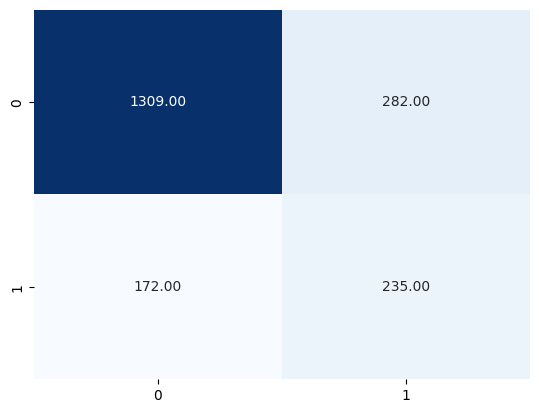

In [88]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred_test),cmap='Blues',cbar=False,annot=True,fmt='.2f')

In [89]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1591
           1       0.45      0.58      0.51       407

    accuracy                           0.77      1998
   macro avg       0.67      0.70      0.68      1998
weighted avg       0.80      0.77      0.78      1998



* `RandomForst`

In [94]:
# 1.using RF -- without considering the imbalancing data
forst_cls=RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42)
forst_cls.fit(X_train_Final,y_train)

# predict and Evalute
y_pred_tring_Forst=forst_cls.predict(X_train_Final)
y_pred_test_Forst=forst_cls.predict(X_test_Final)

# using f1_score
score_tring_Forst=f1_score(y_train,y_pred_tring_Forst)
score_Test_Forst=f1_score(y_test,y_pred_test_Forst)

print(f'The f1_score using RandomForestClassifier model for Training Dataset is {score_tring_Forst*100:.3f}')
print(f'The f1_score using RandomForestClassifier model for Training Dataset is {score_Test_Forst*100:.3f}')

The f1_score using RandomForestClassifier model for Training Dataset is 49.647
The f1_score using RandomForestClassifier model for Training Dataset is 56.376


In [95]:
# 1.using RF -- with  considering the imbalancing data using class_weight
forst_cls=RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42,class_weight=dict_weights)
forst_cls.fit(X_train_Final,y_train)

# predict and Evalute
y_pred_tring_Forst=forst_cls.predict(X_train_Final)
y_pred_test_Forst=forst_cls.predict(X_test_Final)

# using f1_score
score_tring_Forst=f1_score(y_train,y_pred_tring_Forst)
score_Test_Forst=f1_score(y_test,y_pred_test_Forst)

print(f'The f1_score using RandomForestClassifier model for Training Dataset with class_weight : {score_tring_Forst*100:.3f}')
print(f'The f1_score using RandomForestClassifier model for Training Dataset with class_weight : {score_Test_Forst*100:.3f}')

The f1_score using RandomForestClassifier model for Training Dataset with class_weight : 60.874
The f1_score using RandomForestClassifier model for Training Dataset with class_weight : 59.372


In [98]:
# 1.using RF -- with  considering the imbalancing data using SMOTE
forst_cls=RandomForestClassifier(n_estimators=150,max_depth=5,random_state=42)
forst_cls.fit(X_train_res,y_train_res)

# predict and Evalute
y_pred_tring_Forst=forst_cls.predict(X_train_res)
y_pred_test_Forst=forst_cls.predict(X_test_Final)

# using f1_score
score_tring_Forst=f1_score(y_train_res,y_pred_tring_Forst)
score_Test_Forst=f1_score(y_test,y_pred_test_Forst)

print(f'The f1_score using RandomForestClassifier model for Training Dataset with SMOTE : {score_tring_Forst*100:.3f}')
print(f'The f1_score using RandomForestClassifier model for Training Dataset with SMOTE : {score_Test_Forst*100:.3f}')

The f1_score using RandomForestClassifier model for Training Dataset with SMOTE : 79.787
The f1_score using RandomForestClassifier model for Training Dataset with SMOTE : 63.212


* `RF-Tuning` 

In [16]:
forest_base_cls=RandomForestClassifier(random_state=42,class_weight=dict_weights)

params_best_grad={
    'n_estimators': [100,300,350],
    'max_depth': [10, 20, 30,],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_forest=GridSearchCV(estimator=forest_base_cls,param_grid=params_best_grad,cv=5,n_jobs=-1,verbose=2,scoring='f1')
grid_search_forest.fit(X_train_Final,y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.20387984981226537,
                                                            1: 0.7961201501877346},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 350]},
             scoring='f1', verbose=2)

In [17]:
# The best score according to your scoring and the best score on the leaderboard
grid_search_forest.best_score_,grid_search_forest.best_params_

(0.6166654417609863,
 {'max_depth': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 350})

In [18]:
# The forest after tuning
forest_tuned=grid_search_forest.best_estimator_
forest_tuned

RandomForestClassifier(class_weight={0: 0.20387984981226537,
                                     1: 0.7961201501877346},
                       max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=350, random_state=42)

In [19]:
# 1.The forest after tuning
forest_tuned=grid_search_forest.best_estimator_


# predict and Evalute
y_pred_tring_Forst_tuned=forest_tuned.predict(X_train_Final)
y_pred_test_Forst_tuned=forest_tuned.predict(X_test_Final)

# using f1_score
score_tring_Forst_tuned=f1_score(y_train,y_pred_tring_Forst_tuned)
score_Test_Forst_tuned=f1_score(y_test,y_pred_test_Forst_tuned)

print(f'The f1_score using RandomForestClassifier for training model  with class_weight : {score_tring_Forst_tuned*100:.3f}')
print(f'The f1_score using RandomForestClassifier for testing model  with class_weight : {score_Test_Forst_tuned*100:.3f}')

The f1_score using RandomForestClassifier for training model  with class_weight : 76.502
The f1_score using RandomForestClassifier for testing model  with class_weight : 63.329


In [22]:
joblib.dump(forest_tuned,os.path.join(MODELS_FOLDER_PATH,'forest_tuned.pkl'))

['d:\\Education\\DPE\\Churn_Modelling_project\\Notebooks\\..\\models\\forest_tuned.pkl']

In [23]:
forest_tuned.feature_importances_

array([0.07715424, 0.11957968, 0.33838911, 0.07837896, 0.04762279,
       0.01022457, 0.02326965, 0.04329353, 0.19787995, 0.05380406,
       0.01040345])

In [24]:
feature_after=[name.split('__')[1] for name in preprocessor.get_feature_names_out()]
feature_after

['CreditScore',
 'Balance',
 'Age',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'Tenure',
 'NumOfProducts',
 'IsActiveMember',
 'HasCrCard']

In [25]:
# Feature Importance from RF
forest_tuned_importance=pd.DataFrame({'Feature':feature_after,
                                    'importance':forest_tuned.feature_importances_}).sort_values('importance',ascending=False)
forest_tuned_importance

,Feature,importance
2,Age,0.338389
8,NumOfProducts,0.197880
1,Balance,0.119580
3,EstimatedSalary,0.078379
0,CreditScore,0.077154
9,IsActiveMember,0.053804
4,Geography_Germany,0.047623
7,Tenure,0.043294
6,Gender_Male,0.023270
10,HasCrCard,0.010403


* `XGBoost`

In [17]:
xgb_base_clacf=xgb.XGBClassifier(objective='binary:logistic',max_depth=5,learning_rate=0.1,n_estimators=150,random_state=42)

xgb_base_clacf.fit(X_train_Final,y_train)
# predict and Evalute
y_pred_tring_xgb_base_=xgb_base_clacf.predict(X_train_Final)
y_pred_test_xgb_base_=xgb_base_clacf.predict(X_test_Final)

# using f1_score
score_tring_xgb_base_=f1_score(y_train,y_pred_tring_xgb_base_)
score_Test_xgb_base_=f1_score(y_test,y_pred_test_xgb_base_)

print(f'The f1_score using XGBClassifier for training model  this normal : {score_tring_xgb_base_*100:.3f}')
print(f'The f1_score using XGBClassifier for testing model  this normal : {score_Test_xgb_base_*100:.3f}')

The f1_score using XGBClassifier for training model  this normal : 70.166
The f1_score using XGBClassifier for testing model  this normal : 61.087


In [18]:
# scale
scale=(y_train==0).sum() / (y_train==1).sum()

In [19]:
class_weight=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight=class_weight / np.sum(class_weight)
weight_dict=dict(zip(np.unique(y_train),class_weight))
weight_dict

sample_weight=np.array([weight_dict[i] for i in y_train])
sample_weight

array([0.20387985, 0.20387985, 0.20387985, ..., 0.20387985, 0.79612015,
       0.20387985])

In [24]:
# using scale
xgb_base_clacf=xgb.XGBClassifier(objective='binary:logistic',max_depth=5,learning_rate=0.1,n_estimators=150,random_state=42,scale_pos_weight=scale)

xgb_base_clacf.fit(X_train_Final,y_train)
# predict and Evalute
y_pred_tring_xgb_base_=xgb_base_clacf.predict(X_train_Final)
y_pred_test_xgb_base_=xgb_base_clacf.predict(X_test_Final)

# using f1_score
score_tring_xgb_base_=f1_score(y_train,y_pred_tring_xgb_base_)
score_Test_xgb_base_=f1_score(y_test,y_pred_test_xgb_base_)

print(f'The f1_score using XGBClassifier for training model  with scale is : {score_tring_xgb_base_*100:.3f}')
print(f'The f1_score using XGBClassifier for testing model  with cscale is : {score_Test_xgb_base_*100:.3f}')

The f1_score using XGBClassifier for training model  with scale is : 73.262
The f1_score using XGBClassifier for testing model  with cscale is : 62.069


In [ ]:
from xgboost import XGBClassifier
xgb_base_clf = XGBClassifier(random_state=42,max_depth=7,learning_rate=0.1,colsample_bytree=0.9,min_child_weight=3, n_estimators=400, objective='binary:logistic',subsample=0.6)


In [ ]:
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base_clf,
    param_distributions=param_dist,
    cv=5,
    n_jobs=-1,
    n_iter=30,
    scoring='f1',
    verbose=2,
    random_state=42
)

random_search_xgb.fit(X_train_Final,y_train,sample_weight=sample_weight)

In [47]:
from xgboost import XGBClassifier

# Define the model with parameters
xgb_base_clf = XGBClassifier(
    random_state=45,
    max_depth=3,
    learning_rate = 0.06,
    colsample_bytree=0.9,
    reg_alpha = 0.2,
    reg_lambda = 1.5,
    min_child_weight = 5 ,
    n_estimators=400,
    subsample=0.6,
    use_label_encoder=False,  # Prevent label encoder warning
    eval_metric='logloss'     # Necessary for compatibility
)

# Fit the model

xgb_base_clf.fit(X_train_Final,y_train)
# predict and Evalute
y_pred_tring_xgb_base_=xgb_base_clf.predict(X_train_Final)
y_pred_test_xgb_base_=xgb_base_clf.predict(X_test_Final)

# using f1_score
score_tring_xgb_base_=f1_score(y_train,y_pred_tring_xgb_base_)
score_Test_xgb_base_=f1_score(y_test,y_pred_test_xgb_base_)

print(f'The f1_score using XGBClassifier for training model  with scale is : {score_tring_xgb_base_*100:.3f}')
print(f'The f1_score using XGBClassifier for testing model  with cscale is : {score_Test_xgb_base_*100:.3f}')

d:\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


The f1_score using XGBClassifier for training model  with scale is : 64.478
The f1_score using XGBClassifier for testing model  with cscale is : 62.665


In [ ]:
joblib.dump(xgb_base_clf,os.path.join(MODELS_FOLDER_PATH,'XGoost.pkl'))

['d:\\Education\\DPE\\Churn_Modelling_project\\Notebooks\\..\\models\\XGoost.pkl']